# OCR example for recogneze text from table with grey bacground for some cells
## Install spark-ocr python packge
Need specify path to `spark-ocr-assembly-[version].jar` or `secret`

In [1]:
secret = ""
license = ""
version = secret.split("-")[0]
spark_ocr_jar_path = "../../target/scala-2.12"

In [2]:
%%bash
if python -c 'import google.colab' &> /dev/null; then
    echo "Run on Google Colab!"
    echo "Install Open JDK"
    apt-get install -y openjdk-8-jdk-headless -qq > /dev/null
    export JAVA_HOME="/usr/lib/jvm/java-8-openjdk-amd64"
    export PATH="$JAVA_HOME/bin:$PATH"
    java -version
fi

In [3]:
import sys
import os

if 'google.colab' in sys.modules:
  os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
  os.environ["PATH"] = os.environ["JAVA_HOME"] + "/bin:" + os.environ["PATH"]

In [4]:
# install from PYPI using secret
#%pip install spark-ocr==$version+spark30 --extra-index-url=https://pypi.johnsnowlabs.com/$secret --upgrade

In [5]:
# or install from local path
#%pip install ../../python/dist/spark-ocr-1.9.0.tar.gz

## Initialization of spark session
Need specify path to `spark-ocr-assembly-[version].jar` or `secret`

In [6]:
from pyspark.sql import SparkSession
from sparkocr import start

if license:
    os.environ['JSL_OCR_LICENSE'] = license

spark = start(secret=secret, jar_path=spark_ocr_jar_path)
spark

Spark version: 3.4.1
Spark NLP version: 5.1.2
Spark OCR version: 5.1.0



## Imports

In [7]:
from pyspark.ml import PipelineModel
from pyspark.sql import functions as F

from sparkocr.transformers import *
from sparkocr.enums import *
from sparkocr.utils import display_image
from sparkocr.metrics import score

## Define OCR transformers

In [8]:
# Read binary as image
binary_to_image = BinaryToImage()
binary_to_image.setInputCol("content")
binary_to_image.setOutputCol("image")

# Scale image
scaler = ImageScaler()
scaler.setInputCol("image")
scaler.setOutputCol("scaled_image")
scaler.setScaleFactor(1.5)

# Binarize using adaptive tresholding
binarizer = ImageAdaptiveThresholding()
binarizer.setInputCol("scaled_image")
binarizer.setOutputCol("binarized_image")
binarizer.setBlockSize(91)
binarizer.setOffset(20)

# Apply morphology opening
opening = ImageMorphologyOperation()
opening.setKernelShape(KernelShape.SQUARE)
opening.setOperation(MorphologyOperationType.OPENING)
opening.setKernelSize(2)
opening.setInputCol("binarized_image")
opening.setOutputCol("opening_image")

# Remove small objects
remove_objects = ImageRemoveObjects()
remove_objects.setInputCol("binarized_image")
remove_objects.setOutputCol("corrected_image")
remove_objects.setMaxSizeObject(1000)
remove_objects.setMinSizeObject(None)

# Run OCR for each region
ocr_corrected = ImageToText()
ocr_corrected.setInputCol("corrected_image")
ocr_corrected.setOutputCol("text_corrected")
ocr_corrected.setPositionsCol("positions_corrected")
ocr_corrected.setConfidenceThreshold(75)

ocr = ImageToText()
ocr.setInputCol("image")
ocr.setOutputCol("text")

# OCR pipeline
pipeline = PipelineModel(stages=[
    binary_to_image,
    scaler,
    binarizer,
    opening,
    remove_objects,
    ocr,
    ocr_corrected
])

## Read image with noised background

In [9]:
import pkg_resources
imagePath = "data/images/grey_background.png"
image_df = spark.read.format("binaryFile").load(imagePath).cache()
image_df.show()

+--------------------+--------------------+------+--------------------+
|                path|    modificationTime|length|             content|
+--------------------+--------------------+------+--------------------+
|file:/home/jose/s...|2023-03-10 14:41:...|177501|[FF D8 FF E0 00 1...|
+--------------------+--------------------+------+--------------------+



## Run OCR pipelines

In [10]:
result = pipeline \
.transform(image_df).cache()

## Results of simple OCR

In [11]:
print("\n".join([row.text for row in result.select("text").collect()]))

 

 

 

Question: “What would you do as a result of seeing this label posted on a new car's

window? Mark all that apply”

 

 

 

 

 

 

 

 

 

 

 

 

 

Vertical [Horizontal

Sample size 233 223
Write down the MPG rating(s) of the automobile 55% 57%
Write down or record the particular datal was interested in | 53% 60%
Visit the website for more information 45% 45%
Write down the EPA-assigned grade of the automobile 43% x

Scan the QR code (2-D barcode) with my smartphone 15% 13%
Ignore the label and move on to other available information | 14% 7%
Other 6% 2%

 

 

 

 



## Results with preprocessing

In [12]:
print("\n".join([row.text_corrected for row in result.select("text_corrected").collect()]))

Question: “What would you do as a result of seeing this label posted on a new car's
window? Mark all that apply’.

Vertical Horizontal

Sample size 233 223
Write down the MPG rating(s) of the automobile 55% 57%
Write down or record the particular data | was interested in 53% 60%
Visit the website for more information 45% 45%
Write down the EPA-assigned grade of the automobile 43% 4

Scan the QR code (2-D barcode) with my smartphone 15% 13%
Ignore the label and move on to other available information 14% 7%

Other 6% 2%



## Display original and corrected images

Original: file:/home/jose/spark-ocr/workshop/jupyter/data/images/grey_background.png

    Image #0:
    Origin: file:/home/jose/spark-ocr/workshop/jupyter/data/images/grey_background.png
    Resolution: 72 dpi
    Width: 628 px
    Height: 335 px
    Mode: ImageType.TYPE_BYTE_GRAY
    Number of channels: 1


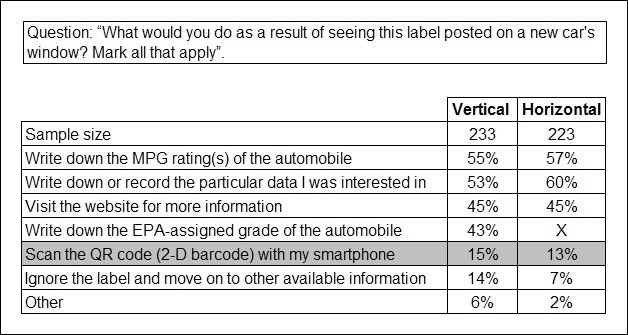

Corrected: file:/home/jose/spark-ocr/workshop/jupyter/data/images/grey_background.png

    Image #0:
    Origin: file:/home/jose/spark-ocr/workshop/jupyter/data/images/grey_background.png
    Resolution: 72 dpi
    Width: 942 px
    Height: 502 px
    Mode: ImageType.TYPE_BYTE_BINARY
    Number of channels: 1


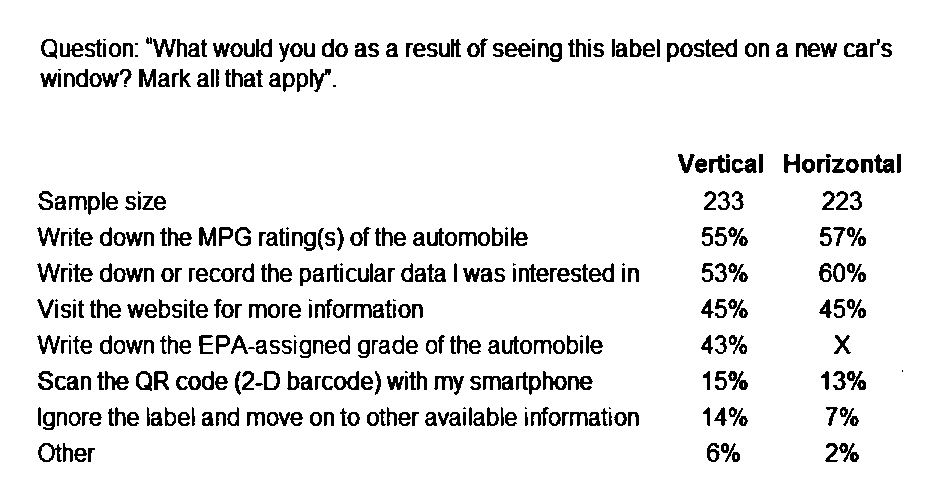

In [13]:
for r in result.distinct().collect():
    print("Original: %s" % r.path)
    display_image(r.image)
    print("Corrected: %s" % r.path)
    display_image(r.corrected_image)

## Compute score and compare results

In [14]:
original_text = """Question: “What would you do as a result of seeing this label posted on a new car's
window? Mark all that apply”.

Vertical Horizontal
Sample size 233 223
Write down the MPG rating(s) of the automobile 55% 57%
Write down or record the particular data I was interested in 53% 60%
Visit the website for more information 45% 45%
Write down the EPA-assigned grade of the automobile 43% X
Scan the QR code (2-D barcode) with my smartphone 15% 13%
Ignore the label and move on to other available information 14% 7%
Other 6% 2%
"""

In [16]:
detected = "\n".join([row.text for row in result.collect()])
detected_corrected = "\n".join([row.text_corrected for row in result.collect()])

# Compute scores
tesseract_score = score(original_text, detected)
corrected_score = score(original_text, detected_corrected)

print("Score for simple Tesseract: {0}".format(tesseract_score))
print("Score Spark NLP: {0}".format(corrected_score))

Score for simple Tesseract: 0.812274368231047
Score Spark NLP: 0.985645933014354
